In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import TiDEModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [2]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [3]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [4]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)


    model = TiDEModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=25,
        output_chunk_length=1,
        num_encoder_layers=3,
        num_decoder_layers=2,
        hidden_size=64,
        temporal_width_past=2,
        temporal_width_future=1,
        use_reversible_instance_norm=True,
        n_epochs=100,
        batch_size=88,
        dropout=0.21681024106774108,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.SmoothL1Loss(),
        optimizer_cls=torch.optim.Adam,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode": "min", "factor": 0.3, "patience": 5, "min_lr": 1e-7},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        random_state=42,
        optimizer_kwargs={"lr": 0.003388720125598311, "weight_decay": 0.0874880175491006e-06}
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.010
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.008
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.008. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU c

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE        MAE        R2  \
Temperature                    2.650650    1.628082   1.244373  0.947044   
Precipitation_accumulated      0.002490    0.049902   0.015391  0.996038   
Humidity                      25.398677    5.039710   3.717660  0.918947   
Wind_Speed_kmh                 0.205814    0.453667   0.338280  0.513151   
Soil_Moisture              21571.772922  146.873323  61.838142  0.965124   
Soil_Temperature               5.316825    2.305824   1.646271  0.926750   
Wind_Dir_Sin                   0.217481    0.466348   0.352866  0.319455   
Wind_Dir_Cos                   0.202839    0.450377   0.328370  0.474531   

                               SMAPE  
Temperature                 7.854531  
Precipitation_accumulated   0.413437  
Humidity                    6.113071  
Wind_Speed_kmh             39.691325  
Soil_Moisture               0.

Metric val_loss improved. New best score: 0.078
Metric val_loss improved by 0.029 >= min_delta = 0.001. New best score: 0.049
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.046
Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.034
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.034. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cor

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE        MAE        R2  \
Temperature                    2.732299    1.652967   1.050754  0.921408   
Precipitation_accumulated    309.841147   17.602305   2.562281  0.992228   
Humidity                      12.556658    3.543538   2.345340  0.900194   
Wind_Speed_kmh                 0.046462    0.215551   0.119295  0.858421   
Soil_Moisture              45153.738926  212.494092  96.709009  0.969970   
Soil_Temperature               4.251809    2.061991   1.198861  0.881419   
Wind_Dir_Sin                   0.085790    0.292898   0.161575  0.639510   
Wind_Dir_Cos                   0.183974    0.428922   0.220947  0.718629   

                                SMAPE  
Temperature                  7.358784  
Precipitation_accumulated    1.426384  
Humidity                     3.032752  
Wind_Speed_kmh             119.550983  
Soil_Moisture            

Metric val_loss improved. New best score: 0.000
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide b

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                 MSE      RMSE       MAE           R2  \
Temperature                 0.301926  0.549478  0.260352     0.946109   
Precipitation_accumulated   0.252515  0.502508  0.461182 -2116.268074   
Humidity                    1.315066  1.146763  0.730011     0.923394   
Wind_Speed_kmh              0.000133  0.011545  0.008686         -inf   
Soil_Moisture              90.680838  9.522649  6.893377     0.932029   
Soil_Temperature            0.484514  0.696070  0.302041     0.923689   
Wind_Dir_Sin                0.000003  0.001766  0.001418         -inf   
Wind_Dir_Cos                0.000003  0.001838  0.001417         -inf   

                                SMAPE  
Temperature                  1.831427  
Precipitation_accumulated    0.100602  
Humidity                     0.843261  
Wind_Speed_kmh             200.000000  
Soil_Moisture                0.108480  
Soil_Tempera

Metric val_loss improved. New best score: 0.000
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide b

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE         R2  \
Temperature                   0.097452   0.312174   0.173659   0.828315   
Precipitation_accumulated     0.443453   0.665923   0.598349 -12.435875   
Humidity                      0.494400   0.703136   0.447027   0.949135   
Wind_Speed_kmh                0.000032   0.005688   0.004513       -inf   
Soil_Moisture              1106.722285  33.267436  15.237622   0.968376   
Soil_Temperature              0.030324   0.174138   0.098928   0.867622   
Wind_Dir_Sin                  0.000004   0.001989   0.001696       -inf   
Wind_Dir_Cos                  0.000005   0.002296   0.001715       -inf   

                                SMAPE  
Temperature                  1.856522  
Precipitation_accumulated    0.130445  
Humidity                     0.493864  
Wind_Speed_kmh             200.000000  
Soil_Moisture                0.257

Metric val_loss improved. New best score: 0.001
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE        R2  \
Temperature                   0.291654   0.540050   0.276715  0.877290   
Precipitation_accumulated     0.323871   0.569096   0.527615 -0.142292   
Humidity                      1.134051   1.064918   0.623593  0.975783   
Wind_Speed_kmh                0.000843   0.029029   0.013249  0.593170   
Soil_Moisture              1172.930263  34.248069  12.220314  0.853677   
Soil_Temperature              0.014550   0.120622   0.078557  0.991032   
Wind_Dir_Sin                  0.014207   0.119192   0.037134  0.753500   
Wind_Dir_Cos                  0.017829   0.133525   0.031550  0.797598   

                                SMAPE  
Temperature                  3.905477  
Precipitation_accumulated    0.114883  
Humidity                     0.748687  
Wind_Speed_kmh             177.862087  
Soil_Moisture                0.212912  
Soi

Metric val_loss improved. New best score: 0.011
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.010
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.010. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE        MAE        R2  \
Temperature                    0.945447    0.972341   0.679582  0.898893   
Precipitation_accumulated      0.710745    0.843057   0.619271  0.387187   
Humidity                       7.221651    2.687313   1.529412  0.937461   
Wind_Speed_kmh                 0.584495    0.764523   0.529261  0.624230   
Soil_Moisture              16118.510854  126.958697  33.402729  0.987524   
Soil_Temperature               0.178760    0.422801   0.269968  0.964453   
Wind_Dir_Sin                   0.411003    0.641096   0.456553  0.141049   
Wind_Dir_Cos                   0.308190    0.555148   0.401197  0.366008   

                               SMAPE  
Temperature                23.917593  
Precipitation_accumulated   0.133978  
Humidity                    1.730167  
Wind_Speed_kmh             71.504099  
Soil_Moisture               0.

Metric val_loss improved. New best score: 0.012
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                  MSE       RMSE        MAE        R2  \
Temperature                  1.844467   1.358112   1.044998  0.931825   
Precipitation_accumulated    0.398697   0.631425   0.599316 -0.314609   
Humidity                    15.125097   3.889100   2.904455  0.900121   
Wind_Speed_kmh               0.525236   0.724732   0.533385  0.562886   
Soil_Moisture              641.542753  25.328694  11.670682  0.891776   
Soil_Temperature             0.498689   0.706179   0.551460  0.955359   
Wind_Dir_Sin                 0.377500   0.614410   0.484656  0.297528   
Wind_Dir_Cos                 0.318756   0.564584   0.449739  0.060572   

                                SMAPE  
Temperature                 11.571132  
Precipitation_accumulated    0.128579  
Humidity                     3.524843  
Wind_Speed_kmh              53.601827  
Soil_Moisture                0.133936  
Soil_Tempera

In [5]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

TiDEModel(output_chunk_shift=0, num_encoder_layers=3, num_decoder_layers=2, decoder_output_dim=16, hidden_size=64, temporal_width_past=2, temporal_width_future=1, temporal_hidden_size_past=None, temporal_hidden_size_future=None, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.21681024106774108, use_static_covariates=True, model_name=model_2, input_chunk_length=25, output_chunk_length=1, use_reversible_instance_norm=True, n_epochs=100, batch_size=88, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f42b62332f0>]}, loss_fn=SmoothL1Loss(), optimizer_cls=<class 'torch.optim.adam.Adam'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={

In [6]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


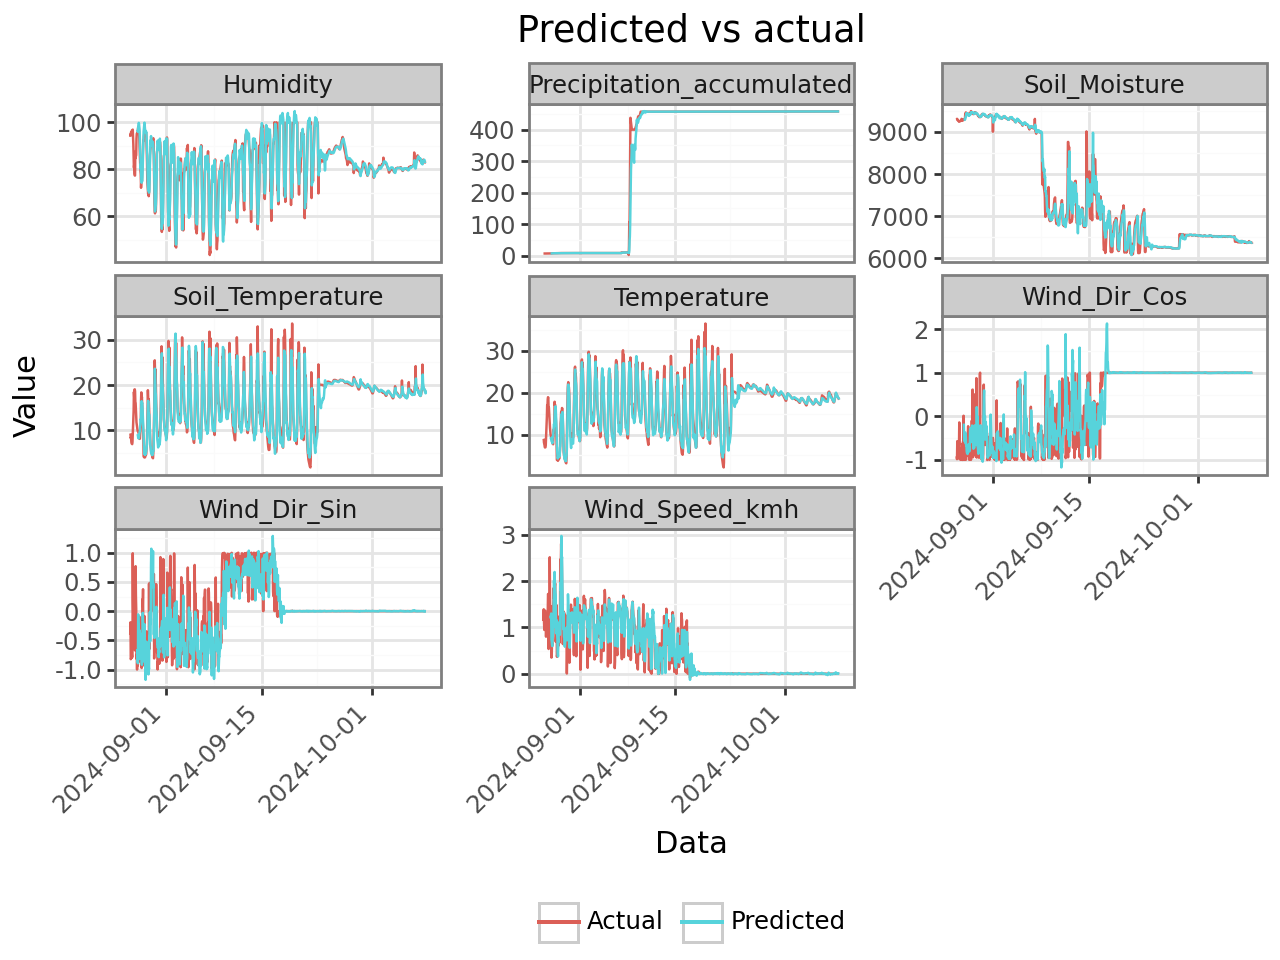

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual.png


In [7]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot.show()
plot.save('predict_actual.png', width=12, height=10, dpi=300)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

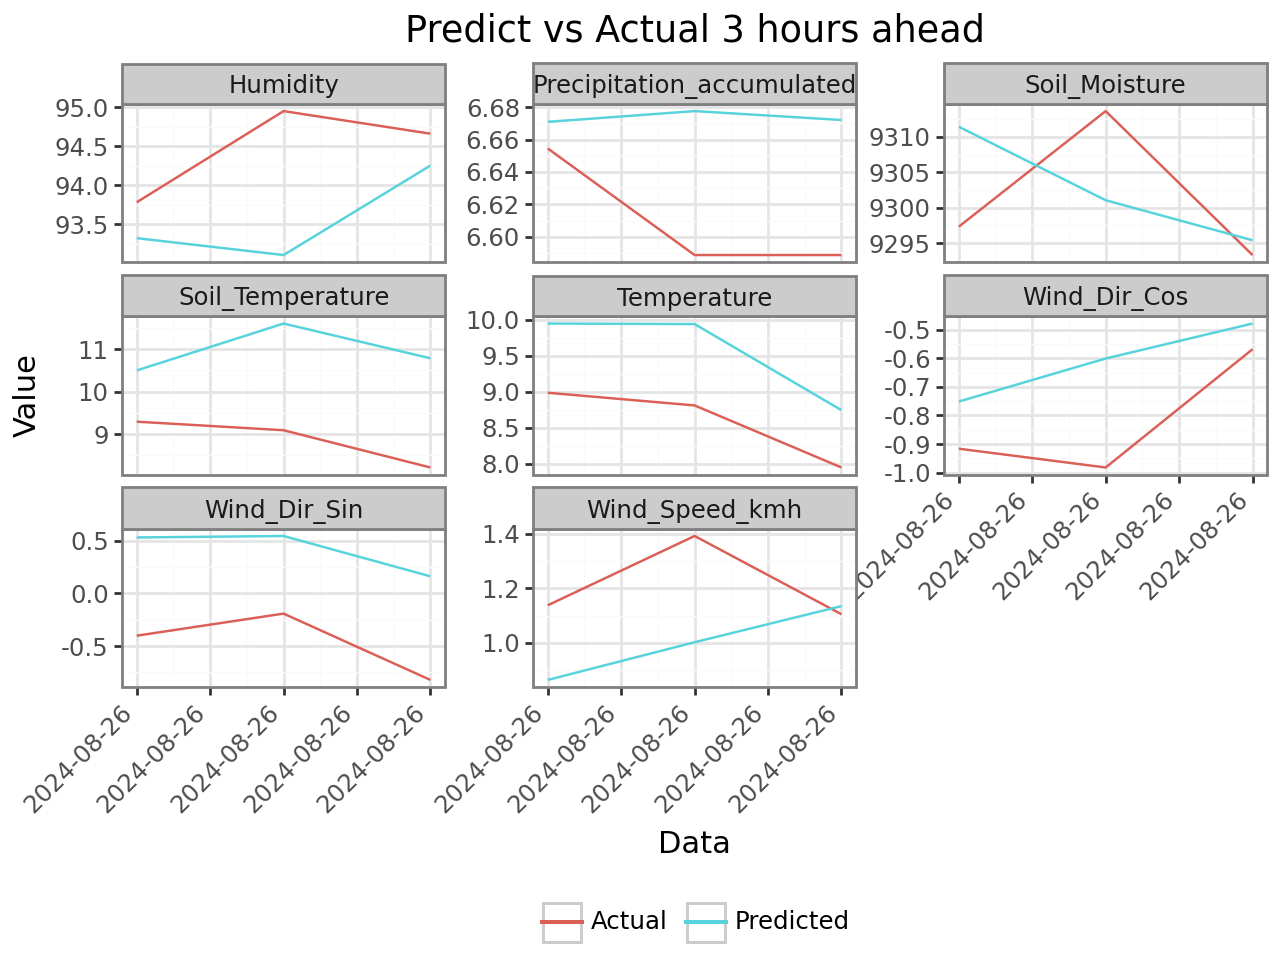

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TiDE/predict_3.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(0.9451515765555826), 'RMSE': np.float64(0.9721890642028342), 'MAE': np.float64(0.9625604619369588), 'R2': np.float64(-3.591596501876931), 'SMAPE': np.float64(10.582928414723753)}, 'Precipitation_accumulated': {'MSE': np.float64(0.005039349559046963), 'RMSE': np.float64(0.07098837622489307), 'MAE': np.float64(0.06289282606510642), 'R2': np.float64(-4.241914465126009), 'SMAPE': np.float64(0.9479684263706988)}, 'Humidity': {'MSE': np.float64(1.26149498965685), 'RMSE': np.float64(1.123162939940973), 'MAE': np.float64(0.9046798742662977), 'R2': np.float64(-4.107414050986963), 'SMAPE': np.float64(0.96229746351142)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.0760464523404324), 'RMSE': np.float64(0.27576521234635887), 'MAE': np.float64(0.23133187730370355), 'R2': np.float64(-3.6150496681210207), 'SMAPE': np.float64(20.876737039283814)}, 'Soil_Moisture': {'MSE': np.float64(120.14705245358552), 'RMSE': np.float64(10.96116109057729), 'MAE': np.float64(9.57602982286

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

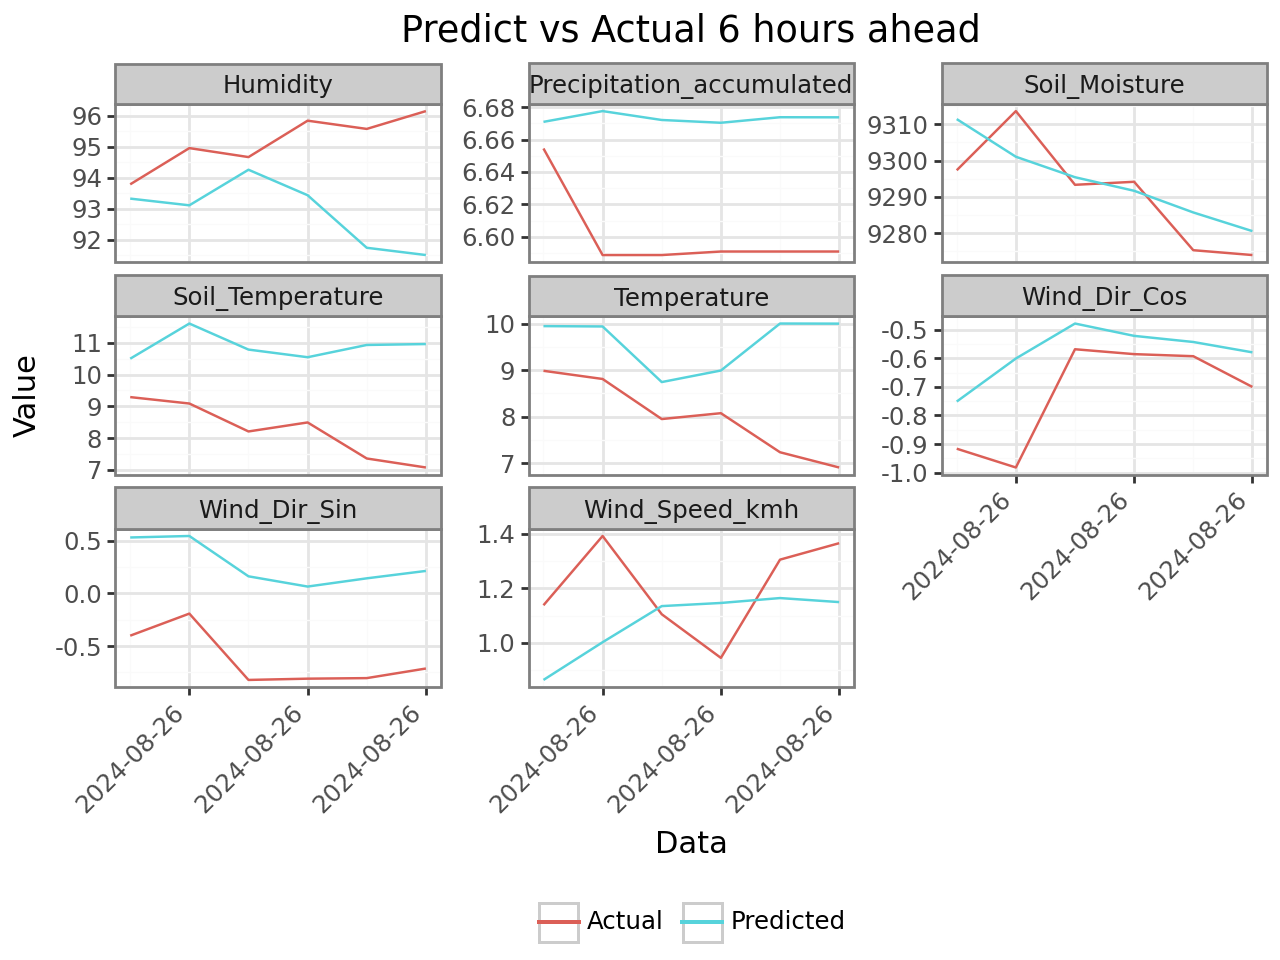

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TiDE/predict_6.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(3.4889553790900503), 'RMSE': np.float64(1.8678745619259476), 'MAE': np.float64(1.6118963619131013), 'R2': np.float64(-5.115962993789817), 'SMAPE': np.float64(18.54489599878644)}, 'Precipitation_accumulated': {'MSE': np.float64(0.005861681047765035), 'RMSE': np.float64(0.0765616160211175), 'MAE': np.float64(0.07231651648174771), 'R2': np.float64(-9.138057773343746), 'SMAPE': np.float64(1.0902623182917874)}, 'Humidity': {'MSE': np.float64(7.637795567497911), 'RMSE': np.float64(2.7636561956035544), 'MAE': np.float64(2.2660096726139236), 'R2': np.float64(-11.109341657266867), 'SMAPE': np.float64(2.4117819586846476)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.0559059942265037), 'RMSE': np.float64(0.23644448444931782), 'MAE': np.float64(0.2088124580431787), 'R2': np.float64(-1.1900930672628012), 'SMAPE': np.float64(18.420939729824696)}, 'Soil_Moisture': {'MSE': np.float64(86.31534799179525), 'RMSE': np.float64(9.290605361966207), 'MAE': np.float64(8.0297770568

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

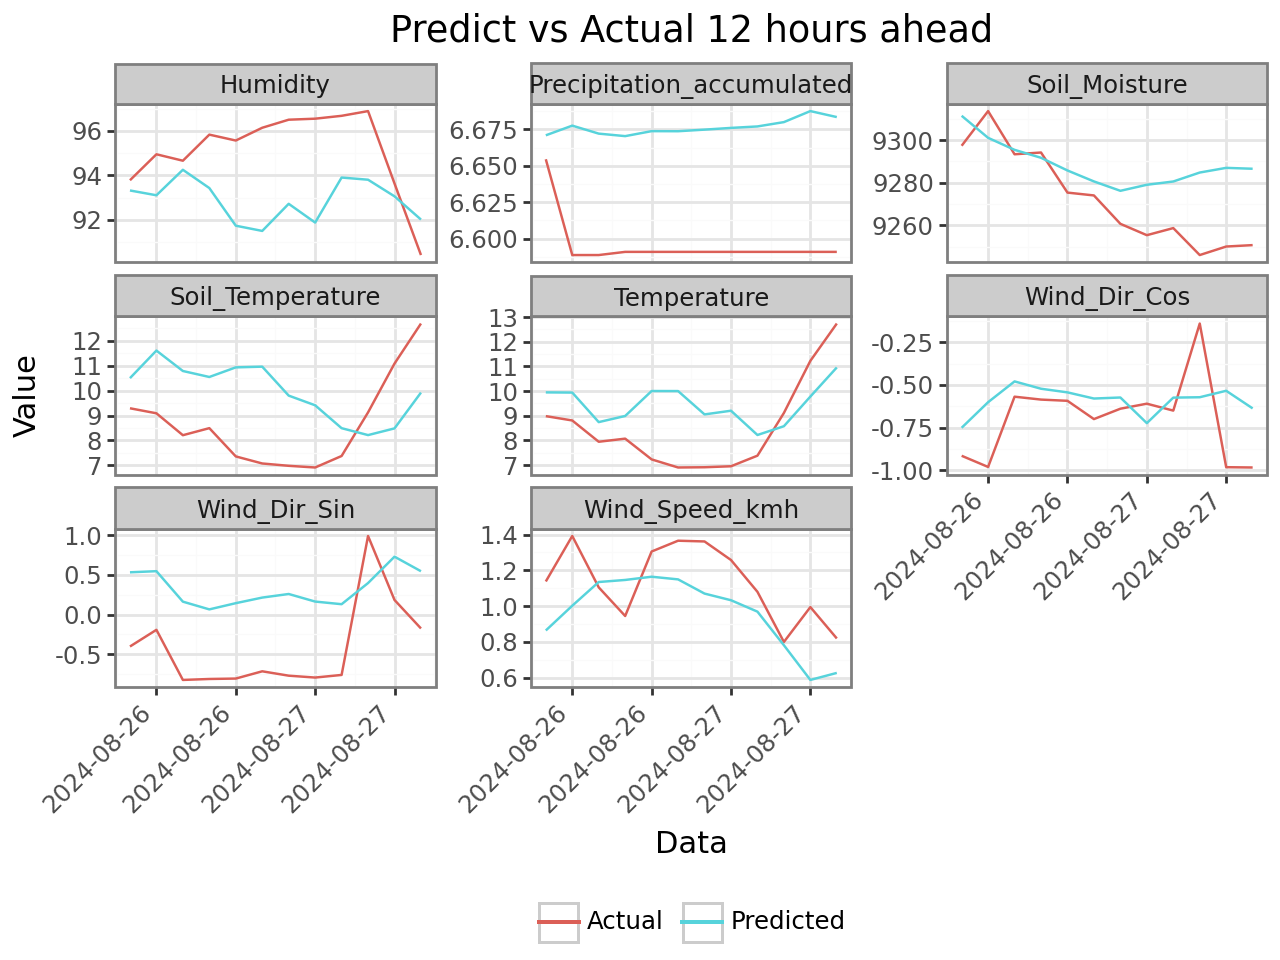

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TiDE/predict_12.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(3.0682465036348123), 'RMSE': np.float64(1.7516410887036227), 'MAE': np.float64(1.555032002106867), 'R2': np.float64(0.0008515270414779508), 'SMAPE': np.float64(17.624817864083056)}, 'Precipitation_accumulated': {'MSE': np.float64(0.00689436723786753), 'RMSE': np.float64(0.08303232646305612), 'MAE': np.float64(0.08061892744469674), 'R2': np.float64(-20.99372328528973), 'SMAPE': np.float64(1.2151786917115548)}, 'Humidity': {'MSE': np.float64(8.513328256118598), 'RMSE': np.float64(2.9177608291494006), 'MAE': np.float64(2.5082406882478665), 'R2': np.float64(-1.7104737869810136), 'SMAPE': np.float64(2.6632262825005903)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.05722818205010644), 'RMSE': np.float64(0.23922412514231595), 'MAE': np.float64(0.20821069059746675), 'R2': np.float64(-0.41063662011621194), 'SMAPE': np.float64(20.45297694335859)}, 'Soil_Moisture': {'MSE': np.float64(495.96247890295353), 'RMSE': np.float64(22.270215061892724), 'MAE': np.float64(18.40

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

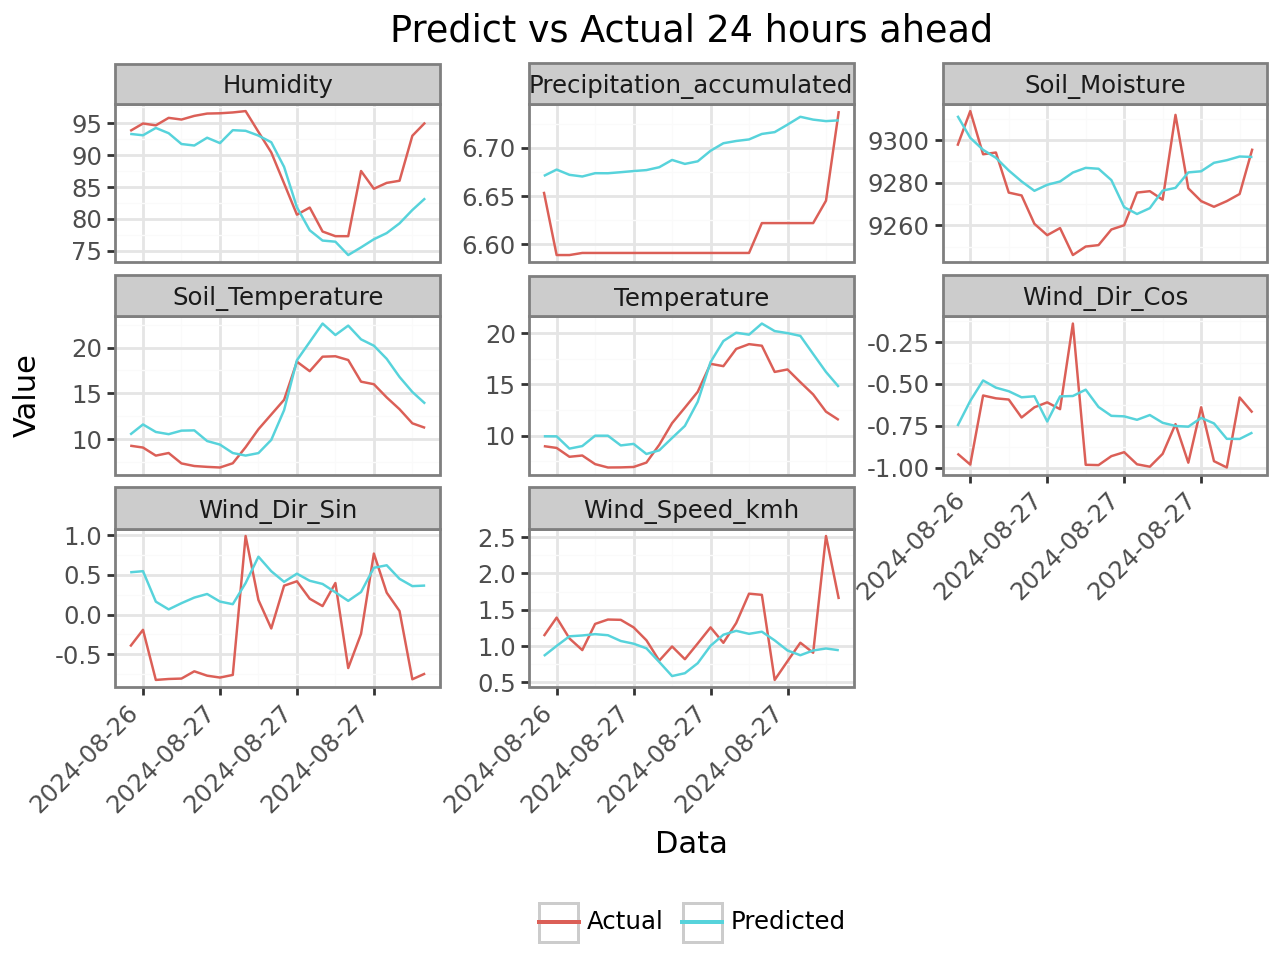

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TiDE/predict_24.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(5.889626973992236), 'RMSE': np.float64(2.4268553673410858), 'MAE': np.float64(2.0821948319854076), 'R2': np.float64(0.6649601008799408), 'SMAPE': np.float64(16.68063353739766)}, 'Precipitation_accumulated': {'MSE': np.float64(0.0084281372807704), 'RMSE': np.float64(0.09180488702008407), 'MAE': np.float64(0.0882191420039173), 'R2': np.float64(-6.677957338925654), 'SMAPE': np.float64(1.326783299006081)}, 'Humidity': {'MSE': np.float64(30.11744745512819), 'RMSE': np.float64(5.487936538912252), 'MAE': np.float64(4.190452326991917), 'R2': np.float64(0.3417161116121785), 'SMAPE': np.float64(4.854457385103593)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.19414206528153732), 'RMSE': np.float64(0.4406155527004662), 'MAE': np.float64(0.3105572483011518), 'R2': np.float64(-0.2291450612712298), 'SMAPE': np.float64(26.632934522075544)}, 'Soil_Moisture': {'MSE': np.float64(387.2679816983545), 'RMSE': np.float64(19.679125531851117), 'MAE': np.float64(16.33320070372224),

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

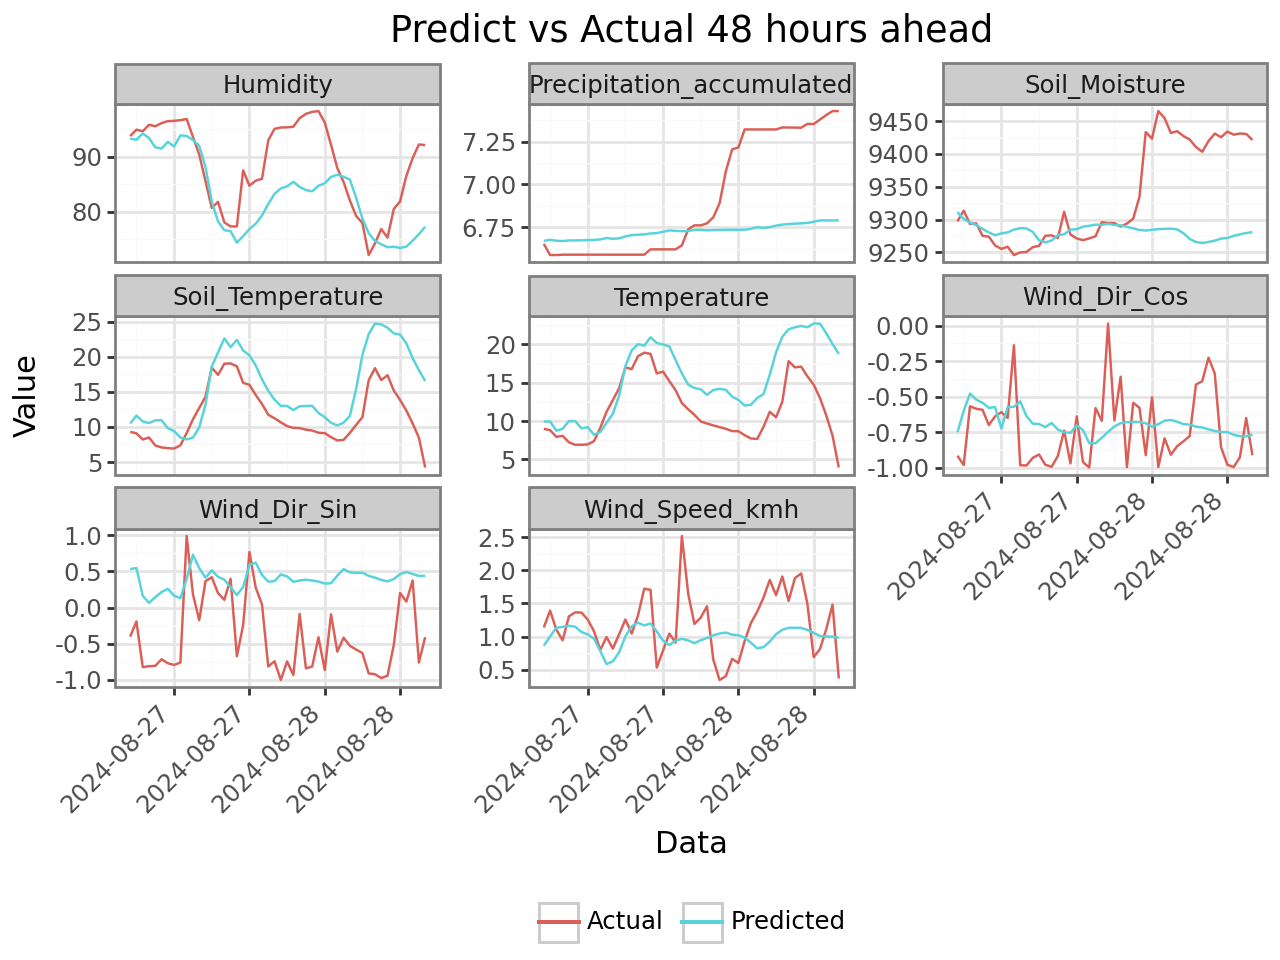

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TiDE/predict_48.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(26.90735092446322), 'RMSE': np.float64(5.187229600129844), 'MAE': np.float64(4.180233214169089), 'R2': np.float64(-0.7926289643285962), 'SMAPE': np.float64(31.3181647097857)}, 'Precipitation_accumulated': {'MSE': np.float64(0.12952620126021774), 'RMSE': np.float64(0.35989748715463094), 'MAE': np.float64(0.2714412408790957), 'R2': np.float64(-0.10954892446629483), 'SMAPE': np.float64(3.893186024957172)}, 'Humidity': {'MSE': np.float64(63.02535195319167), 'RMSE': np.float64(7.938850795498784), 'MAE': np.float64(6.202274828531766), 'R2': np.float64(-0.05024878775094943), 'SMAPE': np.float64(7.214065817868465)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.24163041126918716), 'RMSE': np.float64(0.491559163549198), 'MAE': np.float64(0.39929179815993504), 'R2': np.float64(-0.16642365931696856), 'SMAPE': np.float64(36.272879572626906)}, 'Soil_Moisture': {'MSE': np.float64(9036.494347427944), 'RMSE': np.float64(95.06047731538037), 'MAE': np.float64(67.0138047777901

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

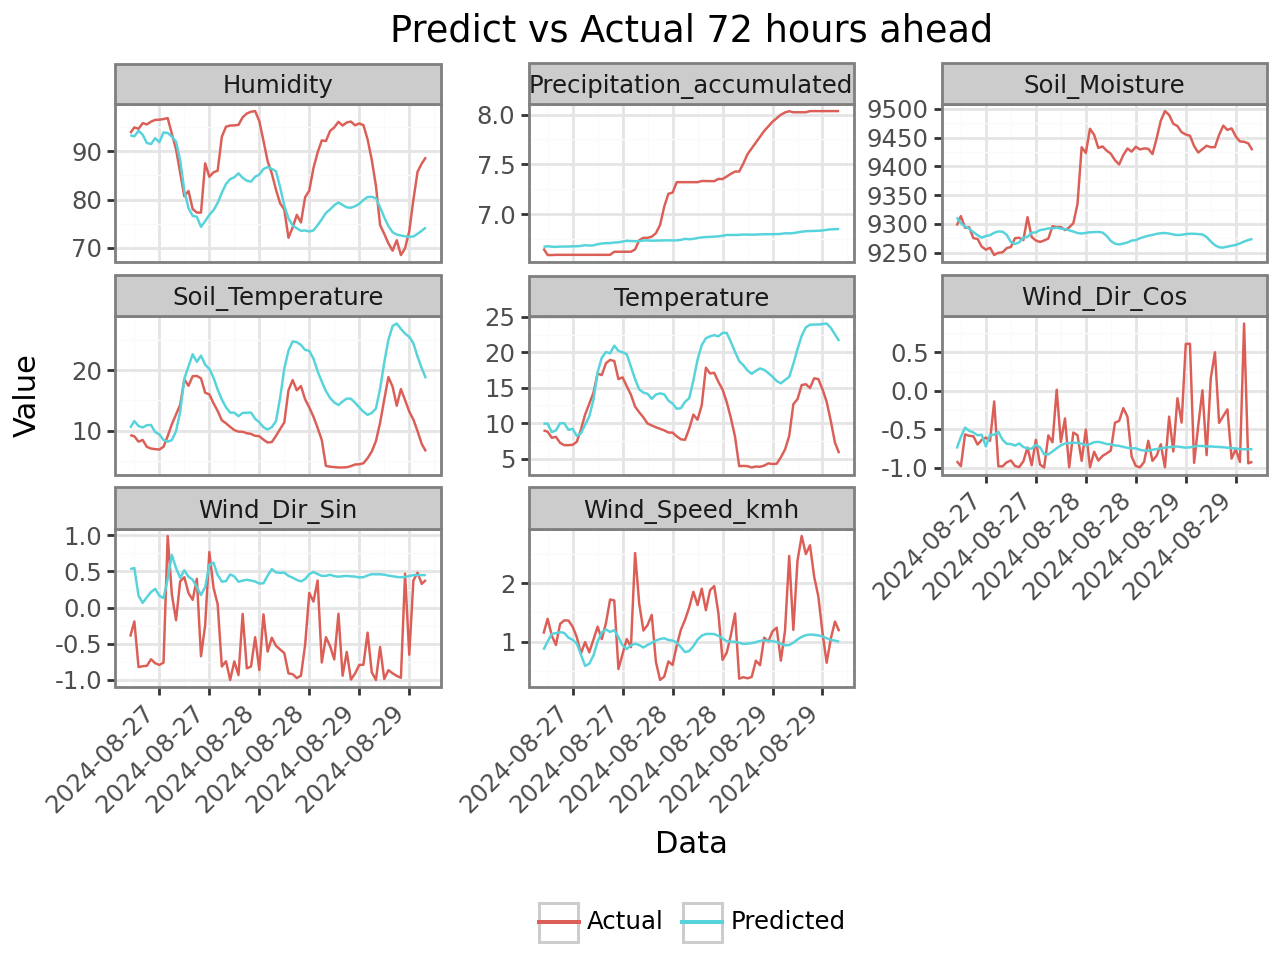

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TiDE/predict_72.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(60.80205077599688), 'RMSE': np.float64(7.797566977974404), 'MAE': np.float64(6.441559927169499), 'R2': np.float64(-2.121387948102355), 'SMAPE': np.float64(49.347564714561685)}, 'Precipitation_accumulated': {'MSE': np.float64(0.5061970739984534), 'RMSE': np.float64(0.711475279963017), 'MAE': np.float64(0.5519969041675766), 'R2': np.float64(-0.5990100231447175), 'SMAPE': np.float64(7.621629562652525)}, 'Humidity': {'MSE': np.float64(89.54807401500227), 'RMSE': np.float64(9.462984413756702), 'MAE': np.float64(7.532981286094923), 'R2': np.float64(-0.1254553037387438), 'SMAPE': np.float64(8.862933268474693)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.36496423555437957), 'RMSE': np.float64(0.6041226990888354), 'MAE': np.float64(0.45899420560032905), 'R2': np.float64(-0.11132827122313116), 'SMAPE': np.float64(39.329237930137104)}, 'Soil_Moisture': {'MSE': np.float64(16813.929390969995), 'RMSE': np.float64(129.66853662693197), 'MAE': np.float64(104.2672730639248

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

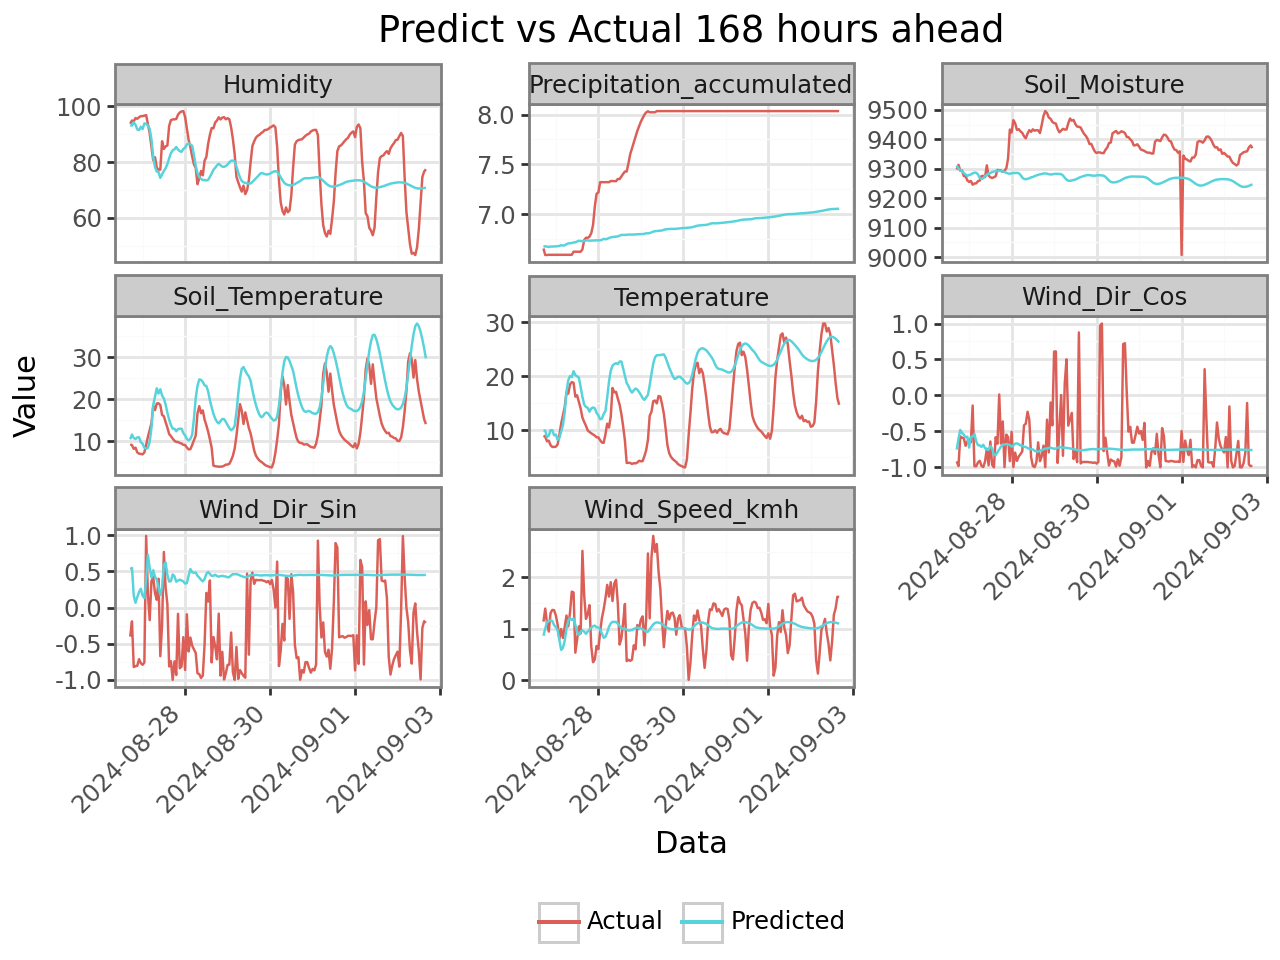

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TiDE/predict_168.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(81.11532235575054), 'RMSE': np.float64(9.006404518771658), 'MAE': np.float64(7.552437518352657), 'R2': np.float64(-0.7499177233966878), 'SMAPE': np.float64(50.708289474299214)}, 'Precipitation_accumulated': {'MSE': np.float64(0.8879263222907143), 'RMSE': np.float64(0.9422984252829432), 'MAE': np.float64(0.854810754037833), 'R2': np.float64(-2.099220477974733), 'SMAPE': np.float64(11.51896185206633)}, 'Humidity': {'MSE': np.float64(155.20277513909997), 'RMSE': np.float64(12.45804058185315), 'MAE': np.float64(10.875653248720866), 'R2': np.float64(0.12809594354211795), 'SMAPE': np.float64(14.103662814794607)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.2504445563436781), 'RMSE': np.float64(0.500444358888856), 'MAE': np.float64(0.3912160446458985), 'R2': np.float64(-0.055795257850479896), 'SMAPE': np.float64(37.51357090989819)}, 'Soil_Moisture': {'MSE': np.float64(15400.387541968106), 'RMSE': np.float64(124.0982979011723), 'MAE': np.float64(110.14517187549713

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

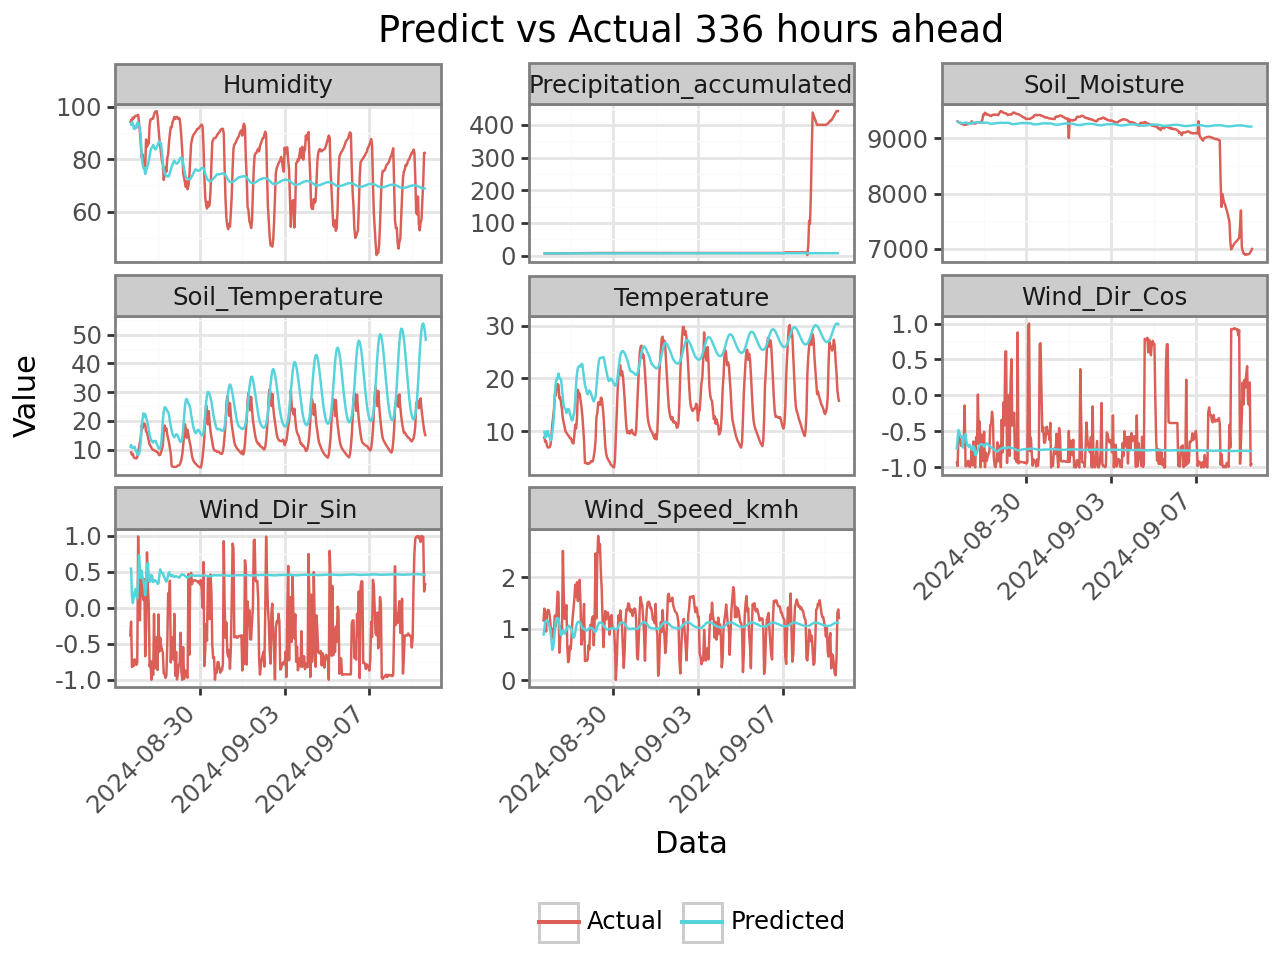

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TiDE/predict_336.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(107.53040235027592), 'RMSE': np.float64(10.36968670453818), 'MAE': np.float64(8.778505689971805), 'R2': np.float64(-1.2643744893257813), 'SMAPE': np.float64(50.44204347338715)}, 'Precipitation_accumulated': {'MSE': np.float64(15830.138409793917), 'RMSE': np.float64(125.81787794186451), 'MAE': np.float64(40.6898245975266), 'R2': np.float64(-0.11458349336747697), 'SMAPE': np.float64(32.440264296860605)}, 'Humidity': {'MSE': np.float64(158.80308808113836), 'RMSE': np.float64(12.601709728490748), 'MAE': np.float64(11.25977150803827), 'R2': np.float64(0.1481589276302968), 'SMAPE': np.float64(15.327345221247242)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.21350296275300135), 'RMSE': np.float64(0.4620638080968919), 'MAE': np.float64(0.3703222022117176), 'R2': np.float64(-0.013103844259990893), 'SMAPE': np.float64(37.837979197588375)}, 'Soil_Moisture': {'MSE': np.float64(451096.16028616106), 'RMSE': np.float64(671.6369259400209), 'MAE': np.float64(308.9439253511

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

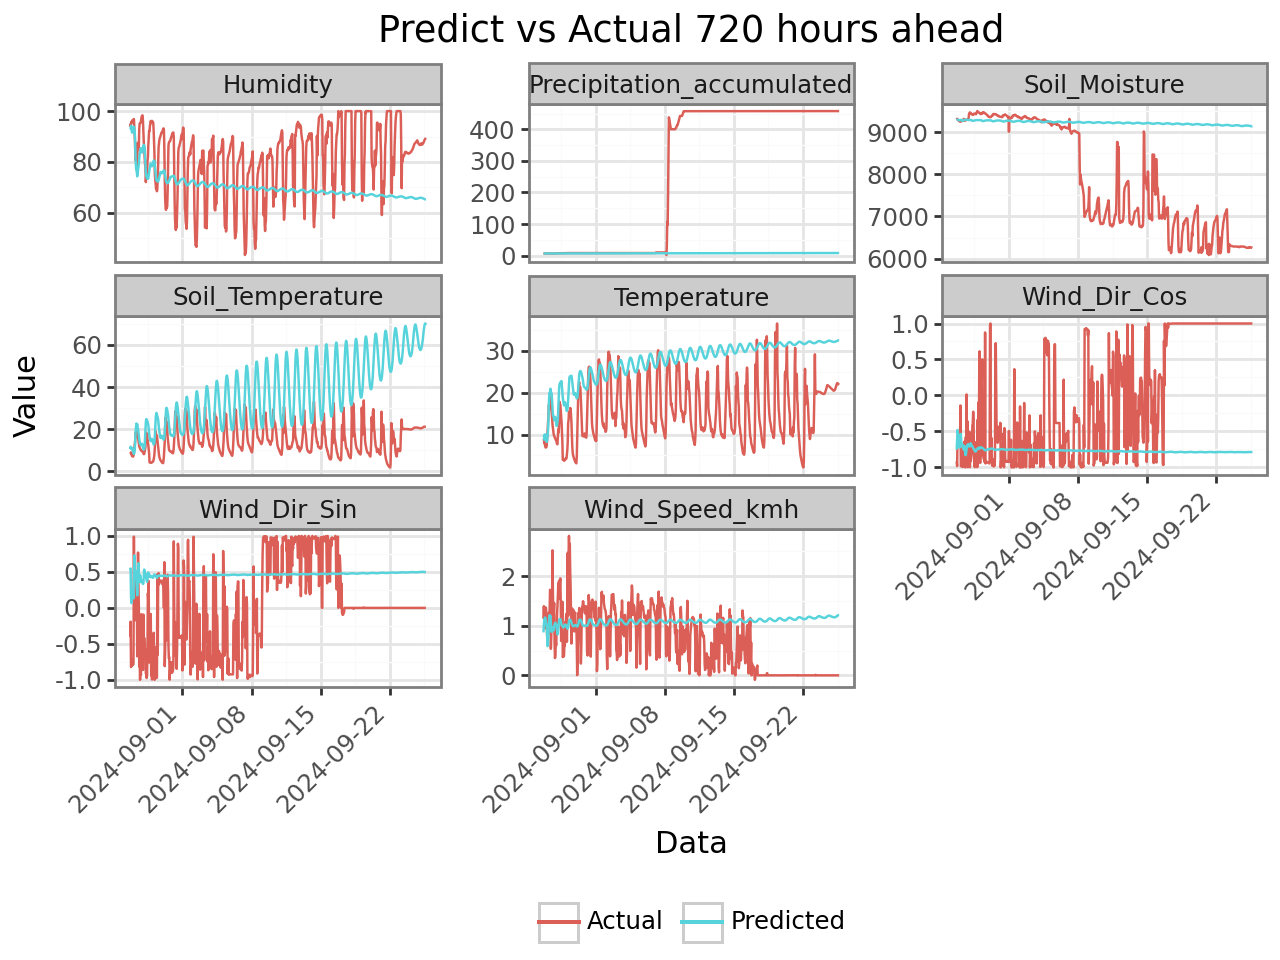

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TiDE/predict_720.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(191.7457486709674), 'RMSE': np.float64(13.847228916681035), 'MAE': np.float64(12.061024215039065), 'R2': np.float64(-3.182685721640114), 'SMAPE': np.float64(60.26251909127)}, 'Precipitation_accumulated': {'MSE': np.float64(115291.39802485671), 'RMSE': np.float64(339.54587028096324), 'MAE': np.float64(258.8809282337574), 'R2': np.float64(-1.3801108892483795), 'SMAPE': np.float64(118.25022823927875)}, 'Humidity': {'MSE': np.float64(329.62002819409963), 'RMSE': np.float64(18.155440732576547), 'MAE': np.float64(15.636274606417935), 'R2': np.float64(-0.8754579350676024), 'SMAPE': np.float64(20.261019598442154)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.5755963461746624), 'RMSE': np.float64(0.758680661526747), 'MAE': np.float64(0.6327251561547579), 'R2': np.float64(-0.6265968291574773), 'SMAPE': np.float64(93.99642810460377)}, 'Soil_Moisture': {'MSE': np.float64(3297827.001164581), 'RMSE': np.float64(1815.992015721595), 'MAE': np.float64(1392.8149149752303), 

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

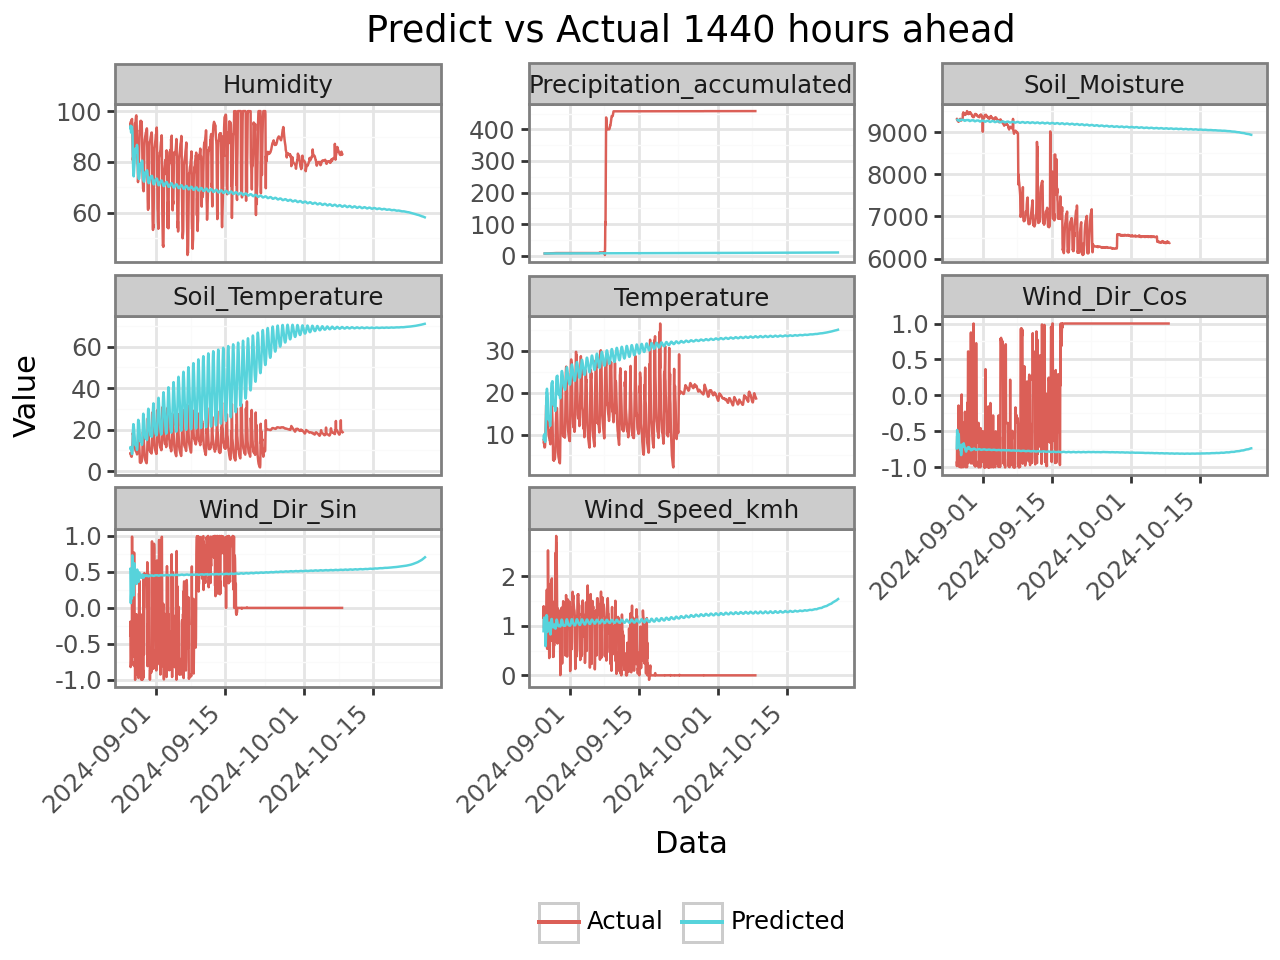

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TiDE/predict_1440.png


{'Temperature': {'MSE': np.float64(191.02673586990673), 'RMSE': np.float64(13.821242197064153), 'MAE': np.float64(12.55812306268799), 'R2': np.float64(-4.478142294426743), 'SMAPE': np.float64(57.93830092408977)}, 'Precipitation_accumulated': {'MSE': np.float64(141882.32115882105), 'RMSE': np.float64(376.67269765516727), 'MAE': np.float64(317.2916014653446), 'R2': np.float64(-2.4262855794237295), 'SMAPE': np.float64(141.0742264575623)}, 'Humidity': {'MSE': np.float64(332.22898415415676), 'RMSE': np.float64(18.227149644257512), 'MAE': np.float64(16.395370684880564), 'R2': np.float64(-1.6485909217986987), 'SMAPE': np.float64(21.62963029957328)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.8673456211222107), 'RMSE': np.float64(0.9313139218986317), 'MAE': np.float64(0.8174929046690891), 'R2': np.float64(-1.566544627939881), 'SMAPE': np.float64(126.47017386138508)}, 'Soil_Moisture': {'MSE': np.float64(4455118.189422534), 'RMSE': np.float64(2110.715089589908), 'MAE': np.float64(1780.1762741154912)

In [8]:
m = "TiDE"
for i in [3,6,12,24,48,72,168,336,720,1440]:
    pred = model.predict(
        series=best_train_scaled,
        n=i,
        verbose=True
    )

    metrics={}

    pred_t = best_scaler.inverse_transform(pred)
    pred_df = pred_t.to_dataframe()
    pred_df = pred_df.reset_index()
    pred_df = pred_df.rename(columns={"time": "Timestamp"})
    plot_columns = ['Timestamp'] + target_columns
    pred_melted = pred_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    pred_melted['type'] = 'Predicted'

    # Get validation data for comparison
    val_t = best_scaler.inverse_transform(best_val_scaled[:i])
    val_df = val_t.to_dataframe()
    val_df = val_df.reset_index()
    val_df = val_df.rename(columns={"time": "Timestamp"})
    val_melted = val_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    val_melted['type'] = 'Actual'

    # Combine predicted and validation data
    combined_df = pd.concat([pred_melted, val_melted])

    plot = (
        ggplot(combined_df, aes(x='Timestamp', y='value', color='type'))
        + geom_line()
        + facet_wrap('~ target_column', scales='free_y')
        + labs(
            title=f'Predict vs Actual {i} hours ahead',
            x='Data',
            y='Value',
            color='Data type'
        )
        + theme_bw()
        + theme(
            axis_text_x=element_text(rotation=45, hjust=1),
            legend_position='bottom',
            legend_title=element_blank(),

        )
    )
    plot.show()
    plot.save(f'results/{m}/predict_{i}.png', width=12, height=10, dpi=300)


    s = best_scaler.inverse_transform(best_val_scaled[:i])
    for target in target_columns:
        metrics[target] = {
            'MSE': mse(s[target], pred_t[target]),
            'RMSE': rmse(s[target], pred_t[target]),
            'MAE': mae(s[target], pred_t[target]),
            'R2': r2_score(s[target], pred_t[target]),
            'SMAPE': smape(s[target], pred_t[target]),
        }
    print(metrics)
    with open(f'results/{m}/metrics{i}.json', 'w') as f:
        json.dump(metrics, f, indent=4)


In [9]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)